In [30]:
import pandas as pd
import numpy as np

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

### 0. Loading

In [31]:
data = pd.read_excel('Cohort analysis.xlsx')
data.sample(3)

,user_id,date,price
514512,XXP197,2021-01-13,50
4260,A2480,2020-02-27,50
34259,D01877,2021-01-13,70


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704840 entries, 0 to 704839
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   user_id  704840 non-null  object        
 1   date     704840 non-null  datetime64[ns]
 2   price    704840 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 16.1+ MB


In [33]:
data.isna().sum() # checking for Nans

user_id    0
date       0
price      0
dtype: int64

### 1. Precalculations and Transformations

In [34]:
### month and year of each purchase

def month_year(x):
    return datetime.datetime(x.year, x.month, 1)

data['month_year'] = data['date'].apply(month_year)
data.sample(3)

,user_id,date,price,month_year
684698,Y1657,2020-12-30,50,2020-12-01
327777,XXC346,2020-07-09,20,2020-07-01
290849,XXA188,2020-06-29,20,2020-06-01


In [35]:
### number of months from the beginning = number of cohorts

data['date'].apply(lambda x: datetime.datetime(x.year, x.month, 1)).nunique()  
# == data['first_purchase'].nunique()

14

In [36]:
### month and year of the very first purchase for each user

data['first_purchase'] = data.groupby('user_id')['month_year'].transform('min') # np.min
data.iloc[6:8]

,user_id,date,price,month_year,first_purchase
6,A0005,2020-03-31,40,2020-03-01,2020-03-01
7,A0005,2020-04-01,100,2020-04-01,2020-03-01


In [37]:
### 1 difference in months between the date of the very first purchase and other purchases for each user == cohort №

year_diff = data['date'].dt.year - data['first_purchase'].dt.year
month_diff = data['date'].dt.month - data['first_purchase'].dt.month

months_number = year_diff * 12 + month_diff + 1

data['cohort_index'] = months_number
data.sample(3)

,user_id,date,price,month_year,first_purchase,cohort_index
552285,XXR302,2020-06-06,300,2020-06-01,2020-05-01,2
246791,U5484,2020-12-11,40,2020-12-01,2020-08-01,5
88032,H3046,2020-09-20,100,2020-09-01,2020-07-01,3


In [38]:
# ### 2 its OK, but long wait

# data['cohort_index_lambda'] = data.apply(lambda x: (x['date'].year - x['first_purchase'].year)*12 + \
#                                                     (x['date'].month - x['first_purchase'].month) + 1, axis=1)

In [39]:
# ### 3 its OK, but long wait and it needs +1 

# data['cohort_index_pandas'] = \
#                    data.apply(lambda x: pd.date_range(x['first_purchase'], x['date'], freq='M').size, axis=1)

In [40]:
# ### 4 its OK

# ### get year and month from date

# def month_and_year(x):
#     year = x.dt.year
#     month = x.dt.month
#     #day = x.dt.day   
#     return year, month

# date_year, date_month = month_and_year(data['date'])
# first_year, first_month = month_and_year(data['first_purchase'])

# ### time from the first order for each current customer order

# diff_year = date_year - first_year
# month_diff = date_month - first_month

# ### cohort № == number of months from the first purchase to the current one

# data['cohort_index_def'] = diff_year * 12 + month_diff + 1

### 2. Cohort Analysis

In [41]:
### Cohort analysis of retention by Number of Purchases (the number of NOT unique customers)

pivot_df = pd.pivot_table(data, 
               index = 'first_purchase', 
               columns = 'cohort_index', 
               values = 'user_id', 
               aggfunc = len)  # 'count'  # just the number of purchases

pivot_df

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13,14
first_purchase,,,,,,,,,,,,,,
2020-01-01,9994.0,8175.0,7099.0,6637.0,6171.0,5127.0,4657.0,4278.0,4110.0,4240.0,3831.0,3791.0,3632.0,761.0
2020-02-01,8463.0,8013.0,5565.0,5593.0,4952.0,4184.0,3293.0,2876.0,2633.0,2172.0,1930.0,1595.0,309.0,NaN
2020-03-01,13210.0,9779.0,8148.0,7837.0,7410.0,6000.0,5634.0,5009.0,4595.0,4604.0,4414.0,899.0,NaN,NaN
2020-04-01,10123.0,8725.0,6272.0,6019.0,5769.0,4106.0,3699.0,3356.0,3358.0,3158.0,605.0,NaN,NaN,NaN
2020-05-01,14982.0,10806.0,8616.0,8336.0,7728.0,6609.0,5956.0,5811.0,5598.0,1137.0,NaN,NaN,NaN,NaN
2020-06-01,11304.0,9783.0,6793.0,6603.0,6294.0,5182.0,4710.0,4241.0,808.0,NaN,NaN,NaN,NaN,NaN
2020-07-01,17007.0,11428.0,8432.0,8273.0,7204.0,6673.0,6218.0,1224.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01,13458.0,10518.0,7241.0,7070.0,6935.0,5753.0,1038.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,17781.0,12152.0,8846.0,8656.0,7829.0,1493.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# calculate as a percentage of the first month

first_column = pivot_df.loc[:, 1] # = pivot_df.iloc[:, 0]

retention = pivot_df.div(first_column.values, axis = 'index')
retention.index = retention.index.date

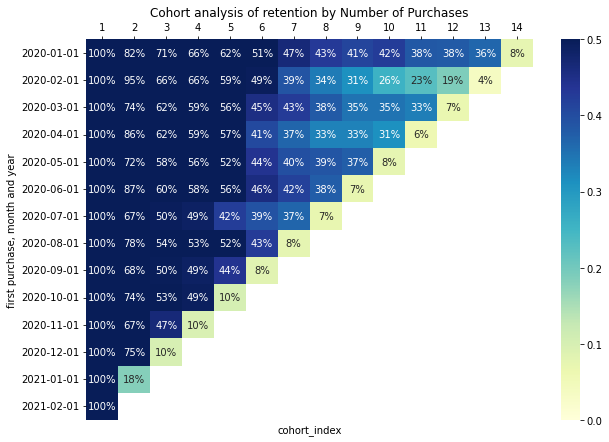

In [43]:
### sns

plt.figure(figsize = (10, 7))
plt.title('Cohort analysis of retention by Number of Purchases')
ax = sns.heatmap(data= retention,
                 cmap= "YlGnBu", annot= True, fmt= '.0%',   # cmap = "crest"
                 vmin= 0.0, vmax= 0.5)    # everything above 0.5 will be the same color and you can see the problem
ax.xaxis.tick_top() 
ax.set(ylabel="first purchase, month and year");

In [44]:
### Cohort analysis of retention by Number of Buyers (unique user id = unique customers)

pivot_df = pd.pivot_table(data, 
               index = 'first_purchase', 
               columns = 'cohort_index', 
               values = 'user_id', 
               aggfunc = 'nunique') 

pivot_df

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13,14
first_purchase,,,,,,,,,,,,,,
2020-01-01,1210.0,455.0,264.0,247.0,242.0,207.0,185.0,172.0,165.0,171.0,164.0,159.0,162.0,149.0
2020-02-01,1111.0,440.0,222.0,202.0,201.0,171.0,133.0,123.0,113.0,90.0,94.0,76.0,62.0,NaN
2020-03-01,1545.0,527.0,306.0,290.0,286.0,250.0,223.0,208.0,186.0,187.0,182.0,175.0,NaN,NaN
2020-04-01,1333.0,515.0,238.0,219.0,228.0,186.0,144.0,143.0,136.0,125.0,111.0,NaN,NaN,NaN
2020-05-01,1738.0,581.0,313.0,301.0,302.0,260.0,240.0,235.0,219.0,206.0,NaN,NaN,NaN,NaN
2020-06-01,1480.0,558.0,265.0,247.0,249.0,216.0,186.0,174.0,153.0,NaN,NaN,NaN,NaN,NaN
2020-07-01,1995.0,649.0,332.0,312.0,293.0,256.0,243.0,224.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01,1744.0,643.0,285.0,265.0,263.0,227.0,196.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,2081.0,701.0,336.0,312.0,303.0,266.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# calculate as a percentage of the first month

first_column = pivot_df.loc[:, 1].values

retention = pivot_df.div(first_column, axis=0)
retention.index = retention.index.date

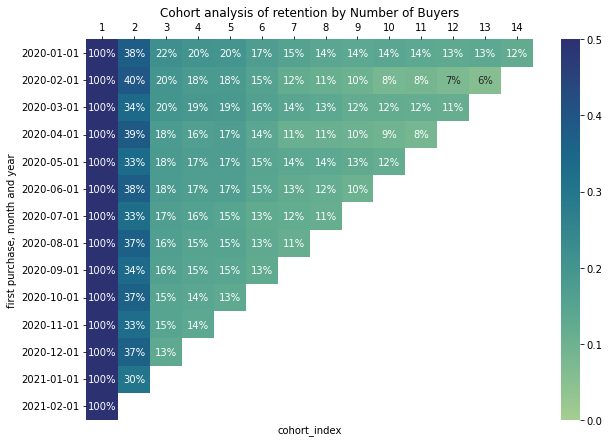

In [46]:
### sns

plt.figure(figsize = (10, 7))
plt.title('Cohort analysis of retention by Number of Buyers')
ax = sns.heatmap(data = retention,
                 cmap = "crest", annot= True, fmt = '.0%',
                 vmin= 0.0, vmax = 0.5);
ax.xaxis.tick_top() 
ax.set(ylabel="first purchase, month and year");

In [47]:
### Cohort analysis of retention by Sum of Purchases

pivot_df = pd.pivot_table(data, 
               index = 'first_purchase', 
               columns = 'cohort_index', 
               values = 'price', 
               aggfunc = sum)

pivot_df

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13,14
first_purchase,,,,,,,,,,,,,,
2020-01-01,662180.0,642990.0,608410.0,565650.0,547080.0,483840.0,455490.0,412040.0,407790.0,428040.0,382000.0,371740.0,360570.0,79310.0
2020-02-01,536310.0,594210.0,445590.0,450500.0,409640.0,366150.0,300350.0,278920.0,251840.0,212570.0,194800.0,156240.0,31080.0,NaN
2020-03-01,873000.0,797300.0,680220.0,666890.0,646610.0,546210.0,542030.0,486430.0,461720.0,465630.0,447040.0,90390.0,NaN,NaN
2020-04-01,648770.0,667480.0,526090.0,503450.0,482350.0,378620.0,354250.0,332740.0,329710.0,314460.0,61750.0,NaN,NaN,NaN
2020-05-01,992030.0,870090.0,737430.0,740850.0,699940.0,633220.0,584100.0,572410.0,568870.0,115380.0,NaN,NaN,NaN,NaN
2020-06-01,718980.0,759810.0,563430.0,559150.0,545300.0,472750.0,453890.0,411240.0,78310.0,NaN,NaN,NaN,NaN,NaN
2020-07-01,1106840.0,913300.0,739440.0,735260.0,661290.0,634590.0,604380.0,124890.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01,844520.0,800350.0,607090.0,586730.0,603010.0,517030.0,94600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,1164460.0,979070.0,784700.0,778600.0,710410.0,140880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# calculate as a percentage of the first month

first_column = pivot_df.loc[:, 1]

retention = pivot_df.div(first_column.values, axis = 'index')
retention.index = retention.index.date

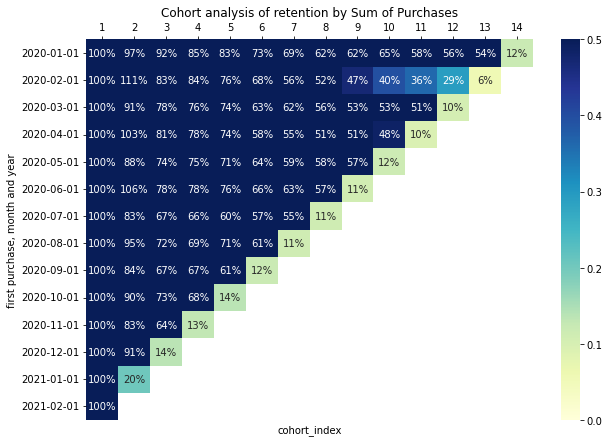

In [49]:
### sns

plt.figure(figsize = (10, 7))
plt.title('Cohort analysis of retention by Sum of Purchases')
ax = sns.heatmap(data= retention,
                 cmap= "YlGnBu", annot= True, fmt= '.0%',
                 vmin= 0.0, vmax= 0.5)
ax.xaxis.tick_top() 
ax.set(ylabel="first purchase, month and year");

In [50]:
### Cohort analysis of retention by MeanSum of Purchases

pivot_df = pd.pivot_table(data, 
               index = 'first_purchase', 
               columns = 'cohort_index', 
               values = 'price', 
               aggfunc = np.mean).round(2)

pivot_df

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13,14
first_purchase,,,,,,,,,,,,,,
2020-01-01,66.26,78.65,85.70,85.23,88.65,94.37,97.81,96.32,99.22,100.95,99.71,98.06,99.28,104.22
2020-02-01,63.37,74.16,80.07,80.55,82.72,87.51,91.21,96.98,95.65,97.87,100.93,97.96,100.58,NaN
2020-03-01,66.09,81.53,83.48,85.10,87.26,91.04,96.21,97.11,100.48,101.14,101.28,100.55,NaN,NaN
2020-04-01,64.09,76.50,83.88,83.64,83.61,92.21,95.77,99.15,98.19,99.58,102.07,NaN,NaN,NaN
2020-05-01,66.21,80.52,85.59,88.87,90.57,95.81,98.07,98.50,101.62,101.48,NaN,NaN,NaN,NaN
2020-06-01,63.60,77.67,82.94,84.68,86.64,91.23,96.37,96.97,96.92,NaN,NaN,NaN,NaN,NaN
2020-07-01,65.08,79.92,87.69,88.87,91.79,95.10,97.20,102.03,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01,62.75,76.09,83.84,82.99,86.95,89.87,91.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,65.49,80.57,88.71,89.95,90.74,94.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# calculate as a percentage of the first month

first_column = pivot_df.loc[:, 1]

retention = pivot_df.div(first_column.values, axis = 'index')
retention.index = retention.index.date

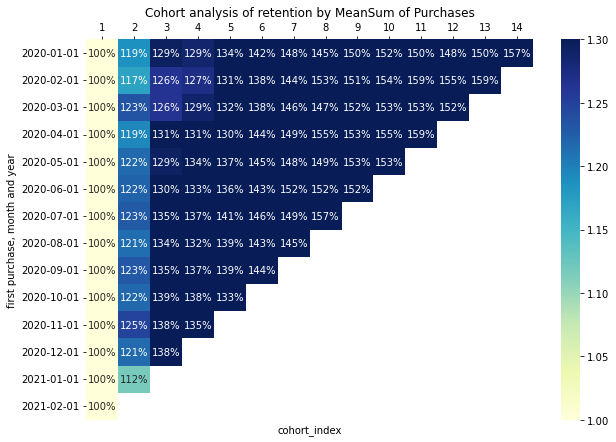

In [52]:
### sns

plt.figure(figsize = (10, 7))
plt.title('Cohort analysis of retention by MeanSum of Purchases')
ax = sns.heatmap(data= retention,
                 cmap= "YlGnBu", annot= True, fmt= '.0%',
                vmin= 1.0, vmax= 1.3)
ax.xaxis.tick_top() 
ax.set(ylabel="first purchase, month and year");